## **Leaflet monthly print-run aggregator + basic statistics & visualization**
- Upload a ZIP archive containing .txt files (filenames only are parsed)
- User defines the value to substitute for unknown print runs ('unk')
- Aggregates print runs per month (YYYY-MM)
- Computes mean, median, ANOVA and Kruskal–Wallis tests
- Saves CSV output and plots bar charts, heatmaps, and cumulative plots

In [2]:
#@title 0) Import libraries
import zipfile
import io
import os
import re
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import pandas as pd
from google.colab import files

In [3]:
#@title 1) Upload ZIP file
print("Upload a ZIP file containing .txt leaflet files.")
uploaded = files.upload()
if not uploaded:
    raise SystemExit("No file uploaded.")
zip_name = next(iter(uploaded.keys()))
zip_bytes = uploaded[zip_name]

Upload a ZIP file containing .txt leaflet files.


Saving latvian_communist_leaflets_1934-1940.zip to latvian_communist_leaflets_1934-1940.zip


In [4]:
#@title 2) Extract filenames from ZIP
z = zipfile.ZipFile(io.BytesIO(zip_bytes))
txt_members = [m for m in z.infolist() if m.filename.lower().endswith('.txt')]
if not txt_members:
    raise SystemExit("No .txt files found in ZIP.")
filenames = [os.path.basename(m.filename) for m in txt_members]

In [5]:
#@title 3) Ask user how to treat unknown print runs ('unk')
print("\nSome files have print_run = 'unk' (unknown).")
raw = input("Enter integer value to use for each 'unk' (default 1000): ").strip()
if raw == "":
    unk_value = 1000
else:
    try:
        unk_value = int(raw)
    except ValueError:
        print("Invalid input, using default 1000.")
        unk_value = 1000
print(f"Using unk = {unk_value} per 'unk' file.\n")


Some files have print_run = 'unk' (unknown).
Enter integer value to use for each 'unk' (default 1000): 1000
Using unk = 1000 per 'unk' file.



In [6]:
#@title 4) Regex patterns for parsing dates and print runs
DATE_RANGE_RE = re.compile(r'(?P<y1>19\d{2})-(?P<m1>\d{2})-(?P<d1>\d{2})\.\.(?P<y2>19\d{2})-(?P<m2>\d{2})-(?P<d2>\d{2})')
DATE_FULL_RE = re.compile(r'(?P<y>19\d{2})[-_](?P<m>\d{2})[-_](?P<d>\d{2})')
DATE_YM_RE = re.compile(r'(?P<y>19\d{2})[-_](?P<m>\d{2})')
PR_RE = re.compile(r'-(?P<pr>\d{1,6}|unk)(?:[-_\.\[]|$)', flags=re.IGNORECASE)

# ---- Helper functions ----
def extract_print_run(fname):
    """Extracts the print run value from filename, returns int or 'unk'."""
    m = PR_RE.search(fname)
    if not m:
        return None
    pr = m.group('pr')
    if pr.lower() == 'unk':
        return 'unk'
    try:
        return int(pr)
    except:
        return None

def extract_year_month(fname):
    """Extracts YYYY-MM string from filename using different date patterns."""
    m_range = DATE_RANGE_RE.search(fname)
    if m_range:
        return f"{m_range.group('y1')}-{m_range.group('m1')}"
    m_full = DATE_FULL_RE.search(fname)
    if m_full:
        return f"{m_full.group('y')}-{m_full.group('m')}"
    m_ym = DATE_YM_RE.search(fname)
    if m_ym:
        return f"{m_ym.group('y')}-{m_ym.group('m')}"
    return None

In [7]:
#@title 5) Aggregate print runs by month
monthly_totals = defaultdict(int)   # total print run per month
monthly_counts = defaultdict(int)   # number of leaflets per month
monthly_values = defaultdict(list)  # list of all print runs per month
unassigned = []

for fname in filenames:
    pr = extract_print_run(fname)
    ym = extract_year_month(fname)
    if ym is None:
        unassigned.append(fname)
        continue
    val = unk_value if pr == 'unk' else (pr if isinstance(pr, int) else 0)
    monthly_totals[ym] += val
    monthly_counts[ym] += 1
    monthly_values[ym].append(val)

if unassigned:
    print("Files with NO parsed 19xx year-month (skipped):")
    for u in unassigned:
        print("  ", u)
    print()

In [8]:
#@title 6) Sort months chronologically
def ym_sort_key(ym):
    y, m = ym.split('-')
    return (int(y), int(m))
sorted_months = sorted(monthly_totals.keys(), key=ym_sort_key)

In [9]:
#@title 7) Compute mean & median per month
print("\n=== Monthly statistics ===")
summary = []
for ym in sorted_months:
    vals = monthly_values[ym]
    mean = np.mean(vals)
    median = np.median(vals)
    summary.append((ym, monthly_totals[ym], monthly_counts[ym], mean, median))
    print(f"{ym}: total={monthly_totals[ym]}, n={monthly_counts[ym]}, mean={mean:.1f}, median={median}")


=== Monthly statistics ===
1934-01: total=30500, n=9, mean=3388.9, median=3000.0
1934-02: total=19000, n=7, mean=2714.3, median=3000.0
1934-03: total=16500, n=7, mean=2357.1, median=1000.0
1934-04: total=34400, n=10, mean=3440.0, median=1750.0
1934-05: total=15500, n=7, mean=2214.3, median=1000.0
1934-06: total=2000, n=2, mean=1000.0, median=1000.0
1934-07: total=31000, n=15, mean=2066.7, median=1000.0
1934-08: total=13050, n=8, mean=1631.2, median=1000.0
1934-09: total=15200, n=7, mean=2171.4, median=1000.0
1934-10: total=18300, n=9, mean=2033.3, median=1000.0
1934-11: total=33000, n=8, mean=4125.0, median=3000.0
1934-12: total=14200, n=6, mean=2366.7, median=1250.0
1935-01: total=22350, n=10, mean=2235.0, median=2000.0
1935-02: total=42350, n=15, mean=2823.3, median=1000.0
1935-03: total=32000, n=10, mean=3200.0, median=3000.0
1935-04: total=30600, n=9, mean=3400.0, median=1000.0
1935-05: total=25000, n=7, mean=3571.4, median=4000.0
1935-06: total=5000, n=2, mean=2500.0, median=2500

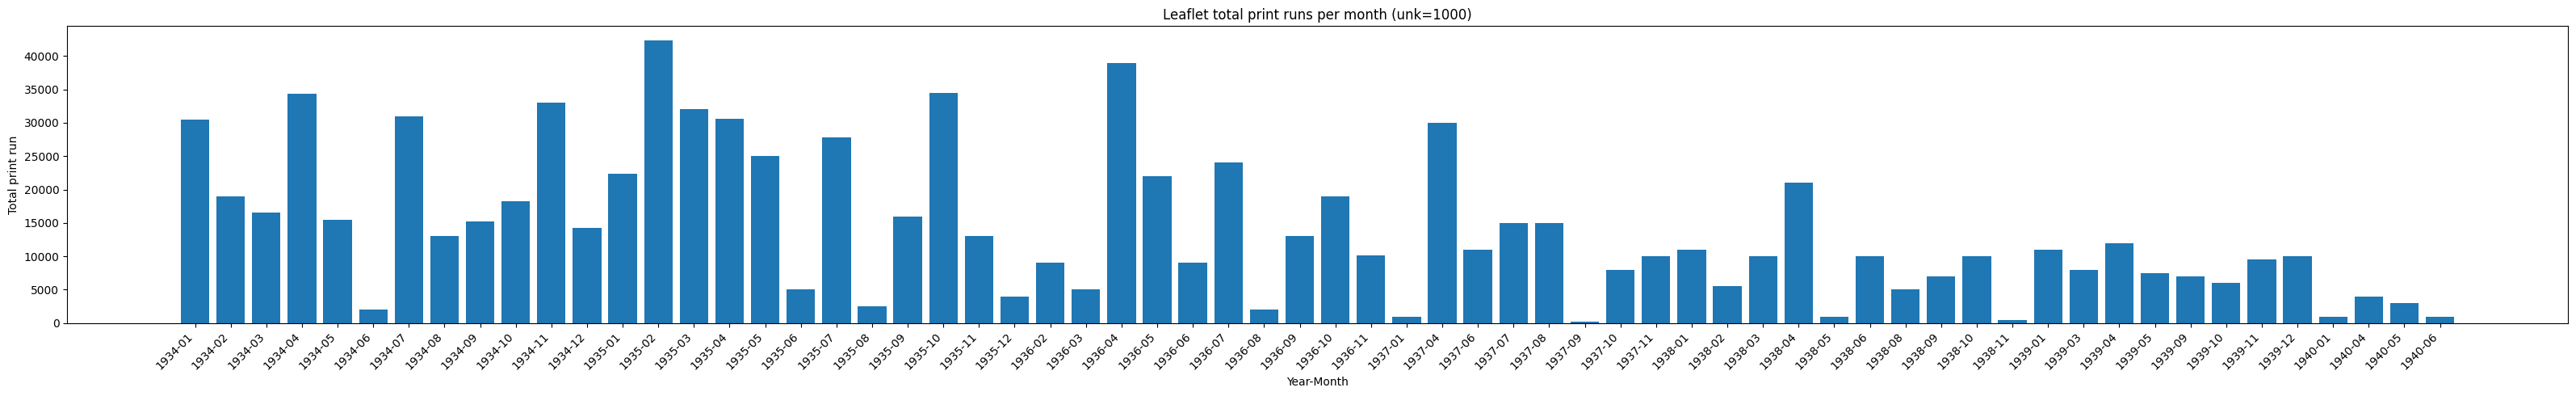

In [10]:
#@title 8) Bar chart of monthly total print runs
labels = sorted_months
values = [monthly_totals[ym] for ym in labels]

plt.figure(figsize=(max(8, len(labels)*0.5), 5))
plt.bar(range(len(values)), values)
plt.xticks(range(len(values)), labels, rotation=45, ha='right')
plt.xlabel('Year-Month')
plt.ylabel('Total print run')
plt.title(f'Leaflet total print runs per month (unk={unk_value})')
plt.tight_layout()
plt.show()

Total unique normalized IDs: 251
Sum over years (should match): 251 

Leaflet counts per year:
1934: 94
1935: 72
1936: 29
1937: 15
1938: 13
1939: 21
1940: 7



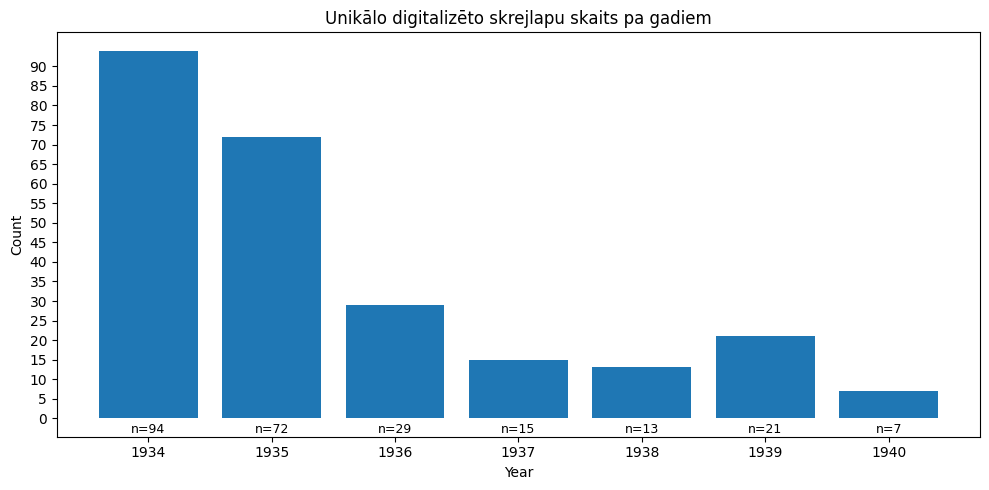

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

# Regex to extract leaflet ID (e.g., 'n197a', 'n251') from filenames like 'revl-n251-...' or 'revl-n001-...'
LEAFLET_ID_RE = re.compile(r'revl-(?P<id>n\d{1,3}[a-z]?)')

def extract_leaflet_id(fname):
    """Extracts leaflet ID from filename."""
    m = LEAFLET_ID_RE.search(fname)
    if m:
        return m.group('id')
    return None

DATE_RANGE_RE = re.compile(r'(?P<y1>19\d{2})-(?P<m1>\d{2})-(?P<d1>\d{2})\.\.(?P<y2>19\d{2})-(?P<m2>\d{2})-(?P<d2>\d{2})')
DATE_FULL_RE = re.compile(r'(?P<y>19\d{2})[-_](?P<m>\d{2})[-_](?P<d>\d{2})')
DATE_YM_RE = re.compile(r'(?P<y>19\d{2})[-_](?P<m>\d{2})')

def extract_full_date_string(fname):
    """Extracts the full date string (YYYY-MM-DD or YYYY-MM) from filename."""
    m_full = DATE_FULL_RE.search(fname)
    if m_full:
        return f"{m_full.group('y')}-{m_full.group('m')}-{m_full.group('d')}"
    m_ym = DATE_YM_RE.search(fname)
    if m_ym:
        return f"{m_ym.group('y')}-{m_ym.group('m')}"
    m_range = DATE_RANGE_RE.search(fname)
    if m_range:
        return f"{m_range.group('y1')}-{m_range.group('m1')}-{m_range.group('d1')}"
    return None

def normalize_id(id_value):
    """
    Returns '197a' and '197b' as '197' to count them as single document.
    All others return the same.
    """
    match = re.search(r'(\d+)', id_value)
    if match:
        return match.group(1)
    return id_value # Return original if no digits found

# Construct a DataFrame `df` from the `filenames` list
# (assuming `filenames` is available from cell 2)
leaflet_data = []
for fname in filenames:
    leaflet_id = extract_leaflet_id(fname)
    date_str = extract_full_date_string(fname)
    # Only add to data if both ID and date are successfully extracted
    if leaflet_id and date_str:
        leaflet_data.append({'id': leaflet_id, 'date': date_str})

df = pd.DataFrame(leaflet_data)

# If no data could be parsed, raise an error or inform the user
if df.empty:
    raise SystemExit("No leaflet data could be parsed from filenames to create DataFrame with 'id' and 'date' columns.")

df["id_normalized"] = df["id"].apply(normalize_id)

# Extract year as integer from date string
df["year"] = df["date"].str[:4].astype(int)

# For each normalized ID choose one canonical year (earliest year it appears)
id_year_min = (
    df.groupby("id_normalized")["year"]
      .min()
      .reset_index(name="year_canonical")
)

# Count unique leaflets per canonical year
leaflets_per_year = (
    id_year_min.groupby("year_canonical")["id_normalized"]
               .size()
               .sort_index()
)

# Sanity checks
print("Total unique normalized IDs:", df["id_normalized"].nunique())
print("Sum over years (should match):", leaflets_per_year.sum(), "\n")

# -------- PRINT leaflet count per year --------
print("Leaflet counts per year:")
for year, count in leaflets_per_year.items():
    print(f"{year}: {count}")
print()  # empty line

# -------- Plot histogram with labels under bars --------
plt.figure(figsize=(10, 5))
x = np.arange(len(leaflets_per_year))
heights = leaflets_per_year.values

plt.bar(x, heights)

# (excluding the same 198a 198b -> 198)
plt.title("Unikālo digitalizēto skrejlapu skaits pa gadiem")
plt.xlabel("Year")
plt.ylabel("Count")

plt.xticks(x, leaflets_per_year.index.astype(str))

max_y = heights.max()
plt.yticks(np.arange(0, max_y + 1, 5))

# Shift bottom to place n=... under bars
bottom = -max_y * 0.05
plt.ylim(bottom=bottom)

# Add n= labels under each bar
for i, cnt in enumerate(heights):
    plt.text(
        i,
        bottom + max_y * 0.001,  # small offset from the bottom
        f"n={cnt}",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()

In [ ]:
#@title 9) Statistical tests: ANOVA / Kruskal–Wallis
print("\n=== Statistical test: Differences between months ===")
groups = [monthly_values[ym] for ym in sorted_months if len(monthly_values[ym]) > 1]
if len(groups) < 2:
    print("Not enough data for statistical test (need ≥2 months with ≥2 values each).")
else:
    f_val, p_val_anova = stats.f_oneway(*groups)
    h_val, p_val_kw = stats.kruskal(*groups)
    print(f"ANOVA: F = {f_val:.3f}, p = {p_val_anova:.5f}")
    print(f"Kruskal–Wallis: H = {h_val:.3f}, p = {p_val_kw:.5f}")
    if p_val_kw < 0.05:
        print("→ Statistically significant difference between months (p < 0.05)")
    else:
        print("→ No significant difference between months (p ≥ 0.05)")

In [ ]:
#@title 10) Heatmap of print runs by month and year
month_year_totals = defaultdict(int)
for ym, vals in monthly_values.items():
    y, m = ym.split('-')
    month_year_totals[(int(y), int(m))] = sum(vals)

years = sorted(set(y for y, m in month_year_totals.keys()))
months = list(range(1,13))

data = []
for y in years:
    row = [month_year_totals.get((y, m), 0) for m in months]
    data.append(row)

df = pd.DataFrame(data, index=years, columns=[f"{m:02d}" for m in months])

plt.figure(figsize=(12,6))
sns.heatmap(df, annot=True, fmt="g", cmap="YlOrRd", linewidths=0.5)
plt.title("Leaflet print runs per month/year")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

In [ ]:
import pandas as pd
from collections import defaultdict
import re

# Assuming regexes from cell 3jL5R49SwOuj are available globally.
# Re-defining them here for clarity if this cell were run in isolation.
# DATE_RANGE_RE = re.compile(r'(?P<y1>19\d{2})-(?P<m1>\d{2})-(?P<d1>\d{2})\.\.(?P<y2>19\d{2})-(?P<m2>\d{2})-(?P<d2>\d{2})')
# DATE_FULL_RE = re.compile(r'(?P<y>19\d{2})[-_](?P<m>\d{2})[-_](?P<d>\d{2})')
# DATE_YM_RE = re.compile(r'(?P<y>19\d{2})[-_](?P<m>\d{2})')

# Regex to extract leaflet ID (e.g., 'n197a', 'n251') from filenames like 'revl-n251-...' or 'revl-n001-...'
LEAFLET_ID_RE = re.compile(r'revl-(?P<id>n\d{1,3}[a-z]?)')

def extract_leaflet_id(fname):
    """Extracts leaflet ID from filename."""
    m = LEAFLET_ID_RE.search(fname)
    if m:
        return m.group('id')
    return None

def extract_full_date_string(fname):
    """Extracts the full date string (YYYY-MM-DD or YYYY-MM) from filename.
       Uses existing DATE_FULL_RE, DATE_YM_RE, DATE_RANGE_RE from cell 3jL5R49SwOuj.
    """
    # Try to extract full date YYYY-MM-DD first
    m_full = DATE_FULL_RE.search(fname)
    if m_full:
        return f"{m_full.group('y')}-{m_full.group('m')}-{m_full.group('d')}"
    # Fallback to YYYY-MM if full date not found
    m_ym = DATE_YM_RE.search(fname)
    if m_ym:
        return f"{m_ym.group('y')}-{m_ym.group('m')}"
    # Fallback to start date of a range if available
    m_range = DATE_RANGE_RE.search(fname)
    if m_range:
        return f"{m_range.group('y1')}-{m_range.group('m1')}-{m_range.group('d1')}"
    return None


# Construct a DataFrame `df` from the `filenames` list
# (assuming `filenames` is available from cell 2)
leaflet_data = []
for fname in filenames:
    leaflet_id = extract_leaflet_id(fname)
    date_str = extract_full_date_string(fname)
    # Only add to data if both ID and date are successfully extracted
    if leaflet_id and date_str:
        leaflet_data.append({'id': leaflet_id, 'date': date_str})

df = pd.DataFrame(leaflet_data)

# If no data could be parsed, raise an error or inform the user
if df.empty:
    raise SystemExit("No leaflet data could be parsed from filenames to create DataFrame with 'id' and 'date' columns.")


def normalize_id(id_value):
    """
    Returns '197a' and '197b' as '197' to count them as single document.
    All others return the same.
    """
    # This regex matches digits in the ID (e.g., 'n197a' -> '197', 'n251' -> '251')
    match = re.search(r'(\d+)', id_value)
    if match:
        return match.group(1)
    return id_value # Return original if no digits found

df["id_normalized"] = df["id"].apply(normalize_id)

unique_leaflets = df["id_normalized"].nunique()

print("Kopējais unikālo skrejlapu skaits:", unique_leaflets)


# === 2) SASKAITĪT SKREJLAPAS PA MĒNEŠIEM ===

leaflet_counts = defaultdict(int)

for _, row in df.iterrows():
    date_str = row["date"]


    parts = date_str.split("-")
    year = int(parts[0])
    # Check if month part exists before trying to convert to int
    month = int(parts[1]) if len(parts) > 1 else None

    if month:
        leaflet_counts[(year, month)] += 1

years = sorted(set(y for y, m in leaflet_counts.keys()))
months = list(range(1, 13))

matrix = []
for y in years:
    row = [leaflet_counts.get((y, m), 0) for m in months]
    matrix.append(row)

df_monthly_leaflets = pd.DataFrame(
    matrix,
    index=years,
    columns=[f"{m:02d}" for m in months]
)

print("\nSkrejlapu skaits pa mēnešiem un gadiem:")
print(df_monthly_leaflets)

plt.figure(figsize=(12, 6))

sns.heatmap(
    df_monthly_leaflets,
    annot=True,
    fmt="g",
    cmap="YlOrRd",
    linewidths=0.5
)

plt.title("Skrejlapu skaits pa mēnešiem un gadiem (1934–1940) (ieskaitot a/b varianti)")
plt.xlabel("Mēnesis")
plt.ylabel("Gads")
plt.show()


In [ ]:
import pandas as pd
from collections import defaultdict
import re

# Regex to extract leaflet ID (e.g., 'n197a', 'n251') from filenames like 'revl-n251-...'
LEAFLET_ID_RE = re.compile(r'revl-(?P<id>n\d{1,3}[a-z]?)')

def extract_leaflet_id(fname: str) -> str | None:
    """Extracts leaflet ID from filename (e.g., 'n197a')."""
    m = LEAFLET_ID_RE.search(fname)
    if m:
        return m.group('id')
    return None

# Very tolerant regex: finds ANY '19xx-MM' in the filename,
# regardless of brackets, ranges, or ellipses.
DATE_YM_ANY_RE = re.compile(r'(19\d{2})[-_](\d{2})')

def extract_year_month(fname: str) -> str | None:
    """
    Extracts year-month (YYYY-MM) from filename.
    Works for patterns like:
      1936-03-18
      1936-03.txt
      [1935-02-01..1935-02-15]
      […1934-11-18]
      1935-01-07… etc.
    It simply finds the first '19xx-MM' substring.
    """
    m = DATE_YM_ANY_RE.search(fname)
    if m:
        year = m.group(1)
        month = m.group(2)
        return f"{year}-{month}"
    return None

def normalize_id(id_value: str) -> str:
    """
    Normalizes leaflet ID:
    'n197a' and 'n197b' -> '197' (counted as a single document).
    'n251' -> '251', etc.
    """
    match = re.search(r'(\d+)', id_value)
    if match:
        return match.group(1)
    return id_value  # fallback

# ---- Build DataFrame from filenames: one row per file ----
rows = []
for fname in filenames:
    leaflet_id = extract_leaflet_id(fname)
    ym = extract_year_month(fname)
    if leaflet_id and ym:
        rows.append({"id": leaflet_id, "year_month": ym})

df = pd.DataFrame(rows)

if df.empty:
    raise SystemExit("No leaflet data could be parsed from filenames (id + year_month).")

# Normalize IDs (merge letter variants)
df["id_normalized"] = df["id"].apply(normalize_id)

# Split year_month into numeric year and month
df["year"] = df["year_month"].str.slice(0, 4).astype(int)
df["month"] = df["year_month"].str.slice(5, 7).astype(int)

# For each normalized ID choose one canonical year-month: earliest (min year, then month)
# We create an integer key like YYYYMM to compare.
df["ym_int"] = df["year"] * 100 + df["month"]

canonical_idx = df.groupby("id_normalized")["ym_int"].idxmin()
df_canonical = df.loc[canonical_idx].copy()

print("Total normalized IDs (unique leaflets):", df["id_normalized"].nunique())
print("Rows in canonical DataFrame:", df_canonical.shape[0])

# === 2) COUNT LEAFLETS PER MONTH (using normalized IDs and canonical year-month) ===

df_monthly_leaflets = (
    df_canonical
      .groupby(["year", "month"])
      .size()
      .unstack(fill_value=0)   # columns = month numbers (1..12)
)

# Ensure all months 1..12 are present as columns
df_monthly_leaflets = df_monthly_leaflets.reindex(columns=range(1, 13), fill_value=0)

# Sort years and rename columns to "01".."12"
df_monthly_leaflets = df_monthly_leaflets.sort_index()
df_monthly_leaflets.columns = [f"{m:02d}" for m in df_monthly_leaflets.columns]

print("\nSkrejlapu skaits pa mēnešiem un gadiem (unikālie dokumenti, pēc normalizētiem ID):")
print(df_monthly_leaflets)

# Check that the sum over all cells equals the number of unique normalized IDs
print("\nSum over all cells in table:", int(df_monthly_leaflets.values.sum()))

plt.figure(figsize=(12, 6))
sns.heatmap(
    df_monthly_leaflets,
    annot=True,
    fmt="g",
    cmap="YlOrRd",
    linewidths=0.5
)

# (tikai unikālie dokumenti, burta sufiksa versijas nav skaitītas atsevišķi)
plt.title("Unikālo digitalizēto skrejlapu skaits pa mēnešiem (1934–1940)")
plt.xlabel("Mēnesis")
plt.ylabel("Gads")
plt.show()


In [ ]:
#@title 11) Month-to-month change
sorted_months = sorted(monthly_totals.keys(), key=ym_sort_key)
changes = []
labels = []

previous_total = None
for ym in sorted_months:
    total = monthly_totals[ym]
    if previous_total is None:
        change = 0
    else:
        change = total - previous_total
    previous_total = total
    changes.append(change)
    labels.append(ym)
    print(f"{ym}: change from previous month = {change}")

# ---- Plot ----
plt.figure(figsize=(max(10, len(labels)*0.5), 5))
plt.bar(range(len(changes)), changes, color='skyblue')
plt.xticks(range(len(labels)), labels, rotation=90)
plt.xlabel('Year-Month')
plt.ylabel('Change from previous month')
plt.title('Leaflet month-to-month change')
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()


In [ ]:
#@title 12) Cumulative print runs per year
year_month_totals = defaultdict(lambda: [0]*12)
for ym, vals in monthly_values.items():
    y, m = ym.split('-')
    year_month_totals[int(y)][int(m)-1] += sum(vals)

plt.figure(figsize=(12,6))
for y, month_totals in sorted(year_month_totals.items()):
    cumulative = np.cumsum(month_totals)
    plt.plot(range(1,13), cumulative, marker='o', label=str(y))

plt.xticks(range(1,13))
plt.xlabel('Month')
plt.ylabel('Cumulative print run')
plt.title('Cumulative leaflet print runs per year')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#@title 13) Annual cumulative print runs (simple histogram)
annual_totals = defaultdict(int)
for ym, vals in monthly_values.items():
    annual_totals[ym[:4]] += sum(vals)

years_sorted = sorted(annual_totals.keys())
totals_sorted = [annual_totals[y] for y in years_sorted]

plt.figure(figsize=(8,5))
plt.bar(years_sorted, totals_sorted, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Total print run')
plt.title('Cumulative leaflet print runs by year')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
#@title 14) Aggregate total monthly print runs across all years
month_year_avg = defaultdict(list)

# Calculate the total print run for each month in each year
for ym, vals in monthly_values.items():
    y, m = ym.split('-')
    month_year_avg[m].append(sum(vals))

# --- Statistical Output ---

# Calculate and print mean/median for each month across all years
for m in sorted(month_year_avg.keys()):
    vals = month_year_avg[m]
    mean = int(round(np.mean(vals)))
    median = int(round(np.median(vals)))
    print(f"{m}: mean={mean}, median={median}, vals={vals}")

# --- Data Visualization ---

# Prepare data for plotting
months = sorted(month_year_avg.keys())
means = [np.mean(month_year_avg[m]) for m in months]
medians = [np.median(month_year_avg[m]) for m in months]

# Create and configure the plot
plt.figure(figsize=(10,5))
x = np.arange(len(months))
plt.plot(x, means, marker='o', label='Mean by month across years')
plt.plot(x, medians, marker='s', label='Median by month across years')
plt.xticks(x, months)
plt.xlabel('Month')
plt.ylabel('Average print run per month')
plt.title('Monthly cyclicity of print runs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#@title 15) Boxplotu grafiki + mēnešu tekstiskais kopsavilkums (Tjūkija noteikumi)

import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict
import numpy as np

# Build month -> {year: sum} map (if monthly_values is per-YYYY-MM lists of leaflets' runs,
# we convert to year-summed totals per month-year)
month_year_sums = defaultdict(lambda: defaultdict(int))
for ym, vals in monthly_values.items():
    # ym like "1934-05"
    try:
        year = int(ym[:4])
        month = ym[5:7]
    except Exception:
        continue
    # interpret vals: these are already the leaflet-level values for that month-year
    # We sum them to get the total print run for that month in that year
    month_year_sums[month][year] += sum(vals)

# Prepare data for plotting and textual summary
months = [f"{i:02d}" for i in range(1,13)]
month_data = []
month_years = []  # parallel list of years lists for reference
for m in months:
    years_dict = month_year_sums.get(m, {})
    # Extract yearly totals sorted by year
    items = sorted(years_dict.items())
    vals = [v for y,v in items]
    yrs = [y for y,v in items]
    month_data.append(vals)
    month_years.append(yrs)

# Create textual summary per calendar month using Tukey definitions for whiskers
print("\n=== Tekstisks kopsavilkums pa kalendāra mēnešiem (gada kopējās tirāžas) ===\n")
for m, vals, yrs in zip(months, month_data, month_years):
    if not vals:
        # skip months with no data
        continue
    arr = np.array(vals, dtype=float)
    n = len(arr)
    total_sum = int(arr.sum())
    mean = float(arr.mean())
    median = float(np.median(arr))
    q1 = float(np.percentile(arr, 25))
    q3 = float(np.percentile(arr, 75))
    iqr = q3 - q1
    # Tukey fences
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    # whiskers: min/max within fences
    non_outliers = arr[(arr >= lower_fence) & (arr <= upper_fence)]
    if non_outliers.size > 0:
        lower_whisker = float(non_outliers.min())
        upper_whisker = float(non_outliers.max())
    else:
        # If all are outliers by Tukey rule, set whiskers to Q1/Q3 as fallback
        lower_whisker = q1
        upper_whisker = q3
    # outliers
    outlier_mask = (arr < lower_whisker) | (arr > upper_whisker)
    outliers = arr[outlier_mask].tolist()
    std = float(arr.std(ddof=0))
    mn = float(arr.min())
    mx = float(arr.max())
    # prepare textual line (latviski)
    yrs_str = ", ".join(str(y) for y in yrs) if yrs else ""
    print(f"Mēnesis {m}: gadu skaits = {n}, gadi = [{yrs_str}]")
    print(f"  Kopējā tirāža visos gados = {total_sum}, vidējā = {int(round(mean))}, mediāna = {int(round(median))}")
    print(f"  Min = {int(mn)}, Q1 = {int(round(q1))}, mediāna = {int(round(median))}, Q3 = {int(round(q3))}, max = {int(mx)}")
    print(f"  IQR = {int(round(iqr))}, apakšējā ūsas robeža = {int(round(lower_whisker))}, augšējā ūsas robeža = {int(round(upper_whisker))}")
    print(f"  Std = {int(round(std))}, izlecēju skaits = {len(outliers)}, izlecēji = {[int(round(x)) for x in outliers]}")
    print("")

# ---- Nicely styled boxplots (white boxes, black edges, orange median, green mean) ----
# Prepare cleaned lists for months that have data
months_with_data = [m for m, d in zip(months, month_data) if len(d) > 0]
data_with_data = [d for d in month_data if len(d) > 0]

fig, ax = plt.subplots(figsize=(12,6))

# boxplot settings
bp = ax.boxplot(
    data_with_data,
    tick_labels=months_with_data,
    showmeans=True,
    patch_artist=True,
    widths=0.6,
    whis=1.5,
    flierprops=dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none', alpha=0.7),
    medianprops=dict(color='orange', linewidth=2),
    meanprops=dict(marker='D', markeredgecolor='green', markerfacecolor='green', markersize=6)
)

# style boxes: white fill, black edge
for box in bp['boxes']:
    box.set(facecolor='white', edgecolor='black', linewidth=1.2)
for whisker in bp['whiskers']:
    whisker.set(color='black', linewidth=1)
for cap in bp['caps']:
    cap.set(color='black', linewidth=1.2)
for median in bp['medians']:
    median.set(color='orange', linewidth=2)

ax.set_ylabel("Gada kopējā tirāža attiecīgajā mēnesī")
ax.set_title("Gada kopējo tirāžu sadalījums pa kalendāra mēnešiem (1934–1940)")
ax.grid(True, which='major', axis='y', linestyle='--', alpha=0.4)

# annotate number of years under each box for convenience
x_positions = range(1, len(months_with_data) + 1)
for x, data_vals in zip(x_positions, data_with_data):
    ax.text(
        x,
        ax.get_ylim()[0] - (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.06,
        f"n={len(data_vals)} gadi",
        ha='center',
        va='top',
        fontsize=9,
        color='black'
    )

plt.tight_layout()
plt.show()


In [ ]:
#@title 16) Save CSV with detailed statistics
csv_path = "monthly_print_runs_with_stats.csv"
with open(csv_path, 'w', encoding='utf-8', newline='') as f:
    writer = csv.writer(f)

    # Column headers
    writer.writerow([
        'year_month',           # "YYYY-MM"
        'year',                 # Year as integer
        'month_number',         # Month number (1-12)
        'total_print_run',      # Total print run for that month
        'n_leaflets',           # Number of leaflets in that month
        'mean_print_run',       # Average print run
        'median_print_run',     # Median print run
        'min_print_run',        # Minimum print run
        'max_print_run',        # Maximum print run
        'std_print_run',        # Standard deviation
        'Q1',                   # First quartile (25th percentile)
        'Q3',                   # Third quartile (75th percentile)
        'IQR',                  # Interquartile range
        'n_outliers',           # Number of outliers (Tukey rule)
        'outliers',             # List of outlier values
        'change_from_prev_month',      # Absolute change from previous month
        'pct_change_from_prev_month',  # Percent change from previous month
        'cumulative_year',            # Cumulative total for that year
        'cumulative_total'            # Cumulative total across all months
    ])

    cumulative_total = 0                  # Running total for all months
    prev_total = None                     # Total of previous month for change calculation
    cumulative_year_dict = defaultdict(int)  # Dictionary for yearly cumulative totals

    for ym, vals, n_leaflets in zip(sorted_months, [monthly_values[ym] for ym in sorted_months], [monthly_counts[ym] for ym in sorted_months]):
        arr = np.array(vals, dtype=float)
        total_sum = int(arr.sum())
        mean = float(arr.mean()) if len(arr) > 0 else 0
        median = float(np.median(arr)) if len(arr) > 0 else 0
        mn = float(arr.min()) if len(arr) > 0 else 0
        mx = float(arr.max()) if len(arr) > 0 else 0
        std = float(arr.std(ddof=0)) if len(arr) > 0 else 0
        q1 = float(np.percentile(arr, 25)) if len(arr) > 0 else 0
        q3 = float(np.percentile(arr, 75)) if len(arr) > 0 else 0
        iqr = q3 - q1

        # Identify outliers using Tukey's method
        lower_fence = q1 - 1.5 * iqr
        upper_fence = q3 + 1.5 * iqr
        outlier_mask = (arr < lower_fence) | (arr > upper_fence)
        outliers = [int(round(x)) for x in arr[outlier_mask]]
        n_outliers = len(outliers)

        # Month-to-month change
        change = 0 if prev_total is None else total_sum - prev_total
        pct_change = 0 if prev_total is None or prev_total == 0 else (change / prev_total) * 100
        prev_total = total_sum

        # Yearly and overall cumulative totals
        year = int(ym[:4])
        month_number = int(ym[5:7])
        cumulative_year_dict[year] += total_sum
        cumulative_year = cumulative_year_dict[year]
        cumulative_total += total_sum

        # Write row to CSV
        writer.writerow([
            ym, year, month_number, total_sum, n_leaflets,
            round(mean,1), round(median,1), int(mn), int(mx),
            round(std,1), int(round(q1)), int(round(q3)), int(round(iqr)),
            n_outliers, str(outliers),
            int(change), round(pct_change,1),
            cumulative_year, cumulative_total
        ])

print(f"\nCSV saved to {csv_path}")
files.download(csv_path)